Import libraries + data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv('/Users/ruthwetters/Downloads/take_home_assign_set.csv')

Inspecting data

In [4]:
df.head()

,age,gender,chest_pain_type,rest_blood_pressure,cholesterol,fast_blood_sugar,rest_ecg,max_heart_rate,ex_ind_ang,prev_peak,slope,vessels_num,thal_result,output
0,63,1,Non-anginal pain,145,233,Yes,Normal,150,No,2.3,0,0,1,1
1,37,1,Atypical angina,130,250,No,ST-T wave normality,187,No,3.5,0,0,2,1
2,41,0,Typical angina,130,204,No,Normal,172,No,1.4,2,0,2,1
3,56,1,Typical angina,120,236,No,ST-T wave normality,178,No,0.8,2,0,2,1
4,57,0,NaN,120,354,No,ST-T wave normality,163,Yes,0.6,2,0,2,1


In [5]:
df.columns

Index(['age', 'gender', 'chest_pain_type', 'rest_blood_pressure',
       'cholesterol', 'fast_blood_sugar', 'rest_ecg', 'max_heart_rate',
       'ex_ind_ang', 'prev_peak', 'slope', 'vessels_num', 'thal_result',
       'output'],
      dtype='object')

In [6]:
df.describe()

,age,gender,rest_blood_pressure,cholesterol,max_heart_rate,prev_peak,slope,vessels_num,thal_result,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,131.623762,246.264026,149.646865,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,17.538143,51.830751,22.905161,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,120.000000,211.000000,133.500000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,130.000000,240.000000,153.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,140.000000,274.500000,166.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,200.000000,564.000000,202.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [7]:
print(df.shape)

(303, 14)


In [8]:
df.groupby('output').describe()

age                                                    gender  \
        count       mean       std   min   25%   50%   75%   max  count   
output                                                                    
0       138.0  56.601449  7.962082  35.0  52.0  58.0  62.0  77.0  138.0   
1       165.0  52.496970  9.550651  29.0  44.0  52.0  59.0  76.0  165.0   

                  ... vessels_num      thal_result                           \
            mean  ...         75%  max       count      mean       std  min   
output            ...                                                         
0       0.826087  ...         2.0  4.0       138.0  2.543478  0.684762  0.0   
1       0.563636  ...         0.0  4.0       165.0  2.121212  0.465752  0.0   

                            
        25%  50%  75%  max  
output                      
0       2.0  3.0  3.0  3.0  
1       2.0  2.0  2.0  3.0  

[2 rows x 72 columns]

mean output is 0.54 so slight class imbalance but not significant enough to use techniques like SMOTE;
model accuracy has to be better than 54% to be better than random chance.
There is also a gender imbalance which could affect results (may be more accurate for men)
This dataset is pretty small, with only 303 records and 13 variables.

In [9]:
#searching for missing values
df.isna().sum()

age                      0
gender                   0
chest_pain_type        143
rest_blood_pressure      0
cholesterol              0
fast_blood_sugar         0
rest_ecg                 0
max_heart_rate           0
ex_ind_ang               0
prev_peak                0
slope                    0
vessels_num              0
thal_result              0
output                   0
dtype: int64

There are a lot of missing values in chest_pain_type: we cannot easily exclude all those records as it would make the dataset even smaller. I could exclude that column, or if I use a model which can cope with missing values then I can leave it in.

In [10]:
#dropping the column with missing values
df = df.drop('chest_pain_type',axis=1)

Dummy variables: 'chest_pain_type','rest_ecg', and 'ex_ind_ang' are all discrete, so can use pd.get_dummies

In [11]:
df = pd.get_dummies(df)

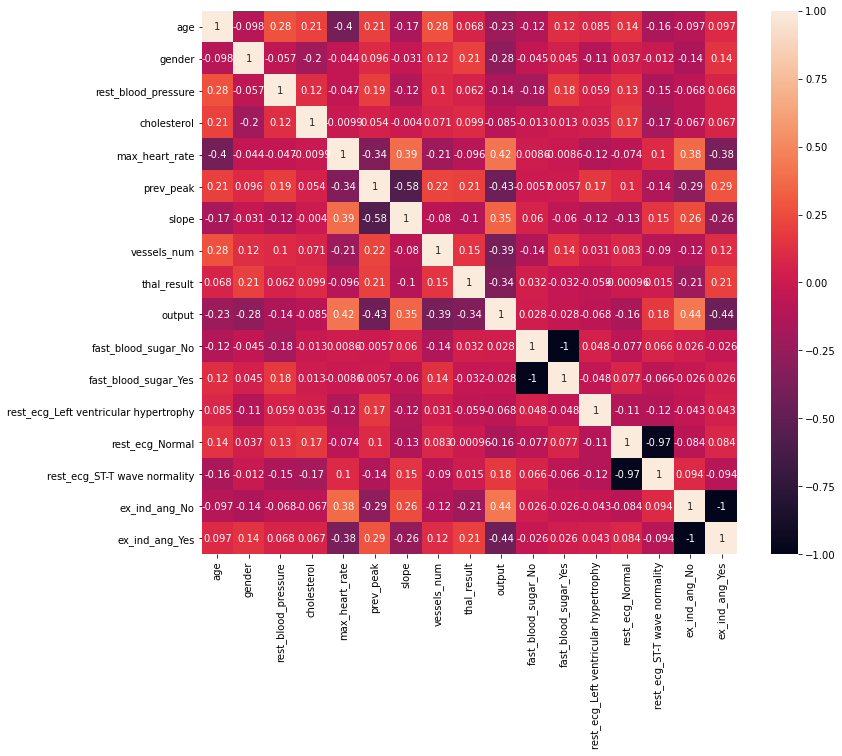

In [12]:
#Checking variable correlation using a correlation matrix
plt.figure(figsize=(12,10))
cor=df.corr()
sn.heatmap(df.corr(), annot=True)
plt.show()

In [13]:
#checking for features which correlate highly with the output variable
cor_target = abs(cor['output'])
relevant_features=cor_target[cor_target>0.5]
relevant_features

output    1.0
Name: output, dtype: float64

Since there are only thirteen variables and none are correlated > 0.95, I would leave them all in the model.

It may be appropriate to use dummy variables for the discrete text variables, but I do not need to do this for the models I have selected.

Model evaluation:
Since this model is predicting heart disease and may be used as a diagnostic tool, the most important thing is to minimise false negatives, so need to optimise for recall. F1 score is also useful, which measures the tradeoff between precision and recall. I will also use AUC which is a good measure of separability of classes.

Model selection: the dataset is small and not too high dimensional, so there is a danger of high variance/overfitting. We therefore need a model with high bias/low variance. The data is highly structured, variables are discrete, so a simple model may be effective. I am training locally, so I do not want something too computationally expensive.  
The simplest is linear regression, so I will try this first. If I get a good performance, I will also try linear SVM, a more complex model. Finally, I will compare this to Random Forest, which is generally an accurate classifier model and has the advantage of being an ensemble model.

In [14]:
#splitting x and y
y = df['output']
X = df.drop(columns=['output'])

In [15]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

When splitting my data into testing, training and validation sets, I chose an 80:20 test/train split and 5-fold cross-validation. I chose 80:20 because of the limited data. I could oversample from one class, but I did not think this was necessary due to the imbalance being only slight.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

Model 1: logistic regression

In [17]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [18]:
y_pred_lr = lr.predict(X_test)

In [31]:
print(metrics.accuracy_score(y_test, y_pred_lr, normalize=True, sample_weight=None))
print(metrics.recall_score(y_test,y_pred_lr))
print(metrics.f1_score(y_test, y_pred_lr, sample_weight=None))

0.819672131147541
0.75
0.8135593220338982


Model 2: random forest

In [20]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [32]:
print(metrics.accuracy_score(y_test, y_pred_rf, sample_weight=None))
print(metrics.recall_score(y_test, y_pred_rf, sample_weight=None))
print(metrics.f1_score(y_test, y_pred_rf, sample_weight=None))

0.8524590163934426
0.875
0.8615384615384615


In [22]:
cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_macro')

array([0.7887931 , 0.83501684, 0.77229602, 0.80566802, 0.76993464])

Model 3: SVM (linear kernel)

In [23]:
SVM = svm.LinearSVC(max_iter=1000,C=1)
SVM.fit(X_train, y_train)
y_pred_svm = SVM.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [33]:
print(metrics.accuracy_score(y_test, y_pred_svm, sample_weight=None))
print(metrics.recall_score(y_test, y_pred_svm, sample_weight=None))
print(metrics.f1_score(y_test, y_pred_svm, sample_weight=None))

0.819672131147541
0.75
0.8135593220338982


In [25]:
#Grid search to optimise RF

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [26]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [29]:
y_pred_rf_random = rf_random.predict(X_test)
print(metrics.recall_score(y_test, y_pred_rf_random, sample_weight=None))
print(metrics.f1_score(y_test, y_pred_rf_random, sample_weight=None))

0.8125
0.8253968253968254


Tried to improve on random forest but it actually reduced the recall, suggesting RF is a good basic model and does not need improving.

Final scores:  
Accuracy 0.85  
Recall 0.875